# General lib imports

In [1]:
import pandas as pd
import numpy as np
from progressbar.bar import ProgressBar
import seaborn as sns

# Code

## Functions

### compute loss, penalty, cost functions, and their derivatives

Equations of the loss functions : 

$$\bullet\ hinge\_loss = \frac{1}{n} \sum _{i=1}^{n}\max\ (0, 1-y_{i}(\mathbf{w}^{T}x_{i}-b))$$
$$\bullet\ squared\_hinge\_loss = \frac{1}{n} \sum _{i=1}^{n}\big(\max\ (0, 1-y_{i}(\mathbf{w}^{T}x_{i}-b))\big)^2$$

In [509]:
def compute_loss(x, y, w, b, loss_type='hinge', derivative=False):
    '''compute the hinge or squared_hinge loss
    returns scalar
    inputs :
        x: shape (n_sample, n_features)
        y: 1/0 binary classes, array or list'''
    
    #converting DataFrames, lists or lists of lists to nparray
    y = (np.array(y)-0.5)*2 #converting 0/1 class into -1/1 
    x = np.array(x)
    
    if loss_type=='hinge':
        if not derivative:
            return np.maximum(0, 1-(np.dot(x,w)-b)*y).mean()
        else:
            hinge_values=np.expand_dims(1-y*(np.dot(x,w)-b),axis=1)
            positives=(hinge_values>0)
            dloss_dw=(positives*(-np.expand_dims(y,axis=1)*x)).mean(axis=0)
            dloss_db=(positives*np.expand_dims(y,axis=1)).mean(axis=0)
            return np.concatenate((dloss_dw, dloss_db),axis=0)
        
    elif loss_type=='squared_hinge':
        if not derivative:
            return np.square(np.maximum(0, 1-(np.dot(x,w)-b)*y)).mean()
        else:
            hinge_values=np.expand_dims(1-y*(np.dot(x,w)-b),axis=1)
            positives=(hinge_values>0)
            dloss_dw=-2*(positives*(np.expand_dims(y,axis=1)*hinge_values*x)).mean(axis=0)
            dloss_db=2*(positives*np.expand_dims(y,axis=1)*hinge_values).mean(axis=0)
            return np.concatenate((dloss_dw, dloss_db),axis=0)

    else:
            raise ValueError(f'unknown loss_type {loss_type}')    

Equations of the penalty functions : 

$$\bullet\ l1\_penalty = \lVert \mathbf{w} \lVert _{l1} = \sum _{j=1}^{p}\lvert w_j \lvert$$
$$\bullet\ l2\_penalty = \lVert \mathbf{w} \lVert^{2} = \sum _{j=1}^{p}\lvert w_j \lvert ^2$$

In [510]:
def compute_penalty(w,penalty_type='l2', derivative=False):
    w=np.array(w)
    if penalty_type=='l2':
        if not derivative:
            return np.dot(w.T,w)
        else:
            return 2*w
    elif penalty_type=='l1':
        if not derivative:
            return np.absolute(w).sum()
        else:
            return np.divide(w, np.absolute(w))
    else:
            raise ValueError(f'unknown penalty_type {penalty_type}')

Equation of the complete cost function :

$$ cost = loss + \alpha \cdot penalty$$
Example with hinge loss and l2 penalty:
$$\Bigg[\frac{1}{n} \sum _{i=1}^{n}\max\ (0, 1-y_{i}(\mathbf{w}^{T}x_{i}-b))\Bigg] + \alpha \lVert \mathbf{w} \lVert^{2} $$

In [511]:
def compute_cost(x, y, params, alpha, loss_type='hinge',
                 penalty_type='l2', derivative=False):
    '''y must be 0/1 binary classes'''
    y = np.array(y)
    x = np.array(x)
    params=np.array(params)
    w = params[:-1]
    b = params[-1]

    #raise errors for unconsistant inputs
    if len(y.shape) > 2:
        raise ValueError('y vect  or dimension too high. Must be 2 max')
        
    if y.shape[0] != x.shape[0]:
        raise ValueError(f'unconsistent vectors dimensions during loss_derivative: \
y.shape= {y.shape} and x.shape= {x.shape}')
        
    if x.shape[1] != w.size:
        raise ValueError(f'unconsistent vectors dimensions during loss_derivative: \
x.shape= {x.shape} and w.size= {w.size}')
        
        
    if derivative==False:
        return compute_loss(x, y, w, b, loss_type, derivative=False)\
               + alpha * compute_penalty(w, penalty_type, derivative=False)
    else:
        return compute_loss(x, y, w, b, loss_type, derivative=True)\
        + alpha * np.concatenate((compute_penalty(w, penalty_type, derivative=True),
                                  np.zeros((1,))),
                                 axis=0)

## functions for display

In [512]:
def compute_line_points(a,b,c):
    '''computes 2 points far away from origin on the line defined by equation 
    a*x + b*y +c = 0
    returns : [x1,x2], [y1,y2]'''
    delta=4 * a**2 * b**2 -4 * (a**2 + b**2) * (c**2 - 10000 * b**2)
    xroot1= (-2*a*c +np.sqrt(delta)) / 2 /(a**2 + b**2)
    xroot2= (-2*a*c -np.sqrt(delta)) / 2 /(a**2 + b**2)
    yroot1=(-c-a*xroot1)/b
    yroot2=(-c-a*xroot2)/b
    return [xroot1,xroot2], [yroot1,yroot2]

In [513]:
def plot_2D_svc(x,y,params):
    '''only in 2D : x.shape=(n_samples,2)
    y.shape=(n_samples,)'''
    if x.shape[1]!=2:
        raise ValueError(f'x.shape={x.shape}. Expected (n_sample,2)')
        
    df=pd.DataFrame({'x1':x[:,0],'x2':x[:,1],'y':y})
    
    xline, yline = compute_line_points(params[0],params[1],-params[2])
    xlineup, ylineup = compute_line_points(params[0],params[1],-params[2]-1)
    xlinedown, ylinedown = compute_line_points(params[0],params[1],-params[2]+1)

    g=sns.scatterplot(data=df,x='x1',y='x2',hue='y')
    sns.lineplot(x=xlinedown, y=ylinedown)
    sns.lineplot(x=xlineup, y=ylineup)
    sns.lineplot(x=xline, y=yline)
    g.set(xlim=(df.x1.min()-2,df.x1.max()+2))
    g.set(ylim=(df.x2.min()-2,df.x2.max()+2))

## Optimizers

In [514]:
class adam_optimizer():
    def __init__(self, params, alpha_init=0.001, beta_1=0.9,
             beta_2=0.999, epsilon=1e-8):
        
        self.alpha_init=alpha_init
        self.beta_1=beta_1
        self.beta_2=beta_2
        self.epsilon=epsilon
    
        self.t=0
        #initializing first and second momentum
        self.m = np.zeros_like(params)
        self.v = self.m.copy()
        
    def get_update(self, gradient):
        self.t+=1
        alpha_t=self.alpha_init*np.sqrt(1-self.beta_2**self.t)/(1-self.beta_1**self.t)
                    
        # updating 1st and 2nd momenta
        self.m=[self.beta_1 * m + (1-self.beta_1) * grad\
                   for m, grad in zip(self.m, gradient)]
        self.v=[self.beta_2 * v + (1-self.beta_2) * grad**2\
                   for v, grad in zip(self.v, gradient)]
        
        #computing the updates
        update = [- alpha_t * m / (np.sqrt(v) + self.epsilon)\
                                  for m, v in zip( self.m, self.v)]
        return update

## Model class

In [519]:
class svc ():
    '''
    hand-made version support vector classifier with softmargin
    so far, the possibilities are :
    
        - param initializers : 'uniform'
    
        - loss functions : 'softmargin_hinge'
            
        - solver : SGD without momentum 'sgd', 'adam'
    '''
    def __init__ (self, input_dim=0, param_initializer='random_uniform'):
        self.input_dim=input_dim
        self.params=np.random.uniform(size=(input_dim + 1,))
        self.cost_history=[]

    def set_input_dim (self, input_dim):
        self.input_dim = input_dim
        self.params=np.random.uniform(size=(input_dim + 1,))
        
    def predict (self, X):
        '''
        Computes binary prediction : wether the point 
        is above or bellow the hyperplane of the svm
        
        Input X : list, list of lists, np array, pd DataFrame
               axis 0 = samples
               axis 1 = features

        Output = y_pred: 1D np-array
               axis 0 = samples
               values : 0/1
           '''
        #converting DataFrames, lists or lists of lists to nparray
        X = np.array(X)
        w = self.params[:-1]
        b = self.params[-1]
        
        #deal with 1D inputs to forge a 1 * n_features 2D-array
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis = 0)
            
        #raise errors for unconsistant inputs
        if len(X.shape) > 2:
            raise ValueError('X vector dimension too high. Must be 2 max')
        if X.shape[1] != self.input_dim:
            raise ValueError(f'Unconsistent number of features. \
The network input_dim is {self.input_dim}')
            
        #compute the prediction

        return ((np.dot(X,w)-b)>0)*1
    
    def predict_distance (self, X):
        '''
        Computes the distance from each data point to the svm hyperplane,
        normalized by the half margin (i.e. that distance=1 is for a point
        lying on the upper boundary of the margin, -1 is for lower boundary)
        
        Input X : list, list of lists, np array, pd DataFrame
               axis 0 = samples
               axis 1 = features

        Output = y_pred: 1D np-array
               axis 0 = samples
               values : distances, normalized by the half margin
           '''
        #converting DataFrames, lists or lists of lists to nparray
        X = np.array(X)
        w = self.params[:-1]
        b = self.params[-1]
        
        #deal with 1D inputs to forge a 1 * n_features 2D-array
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis = 0)
            
        #raise errors for unconsistant inputs
        if len(X.shape) > 2:
            raise ValueError('X vector dimension too high. Must be 2 max')
        if X.shape[1] != self.input_dim:
            raise ValueError(f'Unconsistent number of features. \
The network input_dim is {self.input_dim}')
            
        #compute the prediction

        return np.dot(X,w)-b
    
    def score (self, X, y, metric):
        '''use predict method, then compute_metric function'''
        compute_softmargin_hinge(x, y, params, lambdaa)
        y_pred=self.predict(X)
        return compute_metric(y, y_pred, metric)
            
    
    def fit (self, X, y, loss_type='hinge', penalty_type='l2', alpha=0.01, 
             learning_rate=0.01, batch_size=1, n_epochs=10, verbose=1,
             optimizer_type='sgd', alpha_init=0.001, beta_1=0.9,
             beta_2=0.999, epsilon=1e-8):
        '''input X : 2D array or pd DataFrame
                axis 0 = samples
                axis 1 = features
        '''
        
        if optimizer_type == 'adam':
            optimizer = adam_optimizer (self.params, 
                                        alpha_init=alpha_init, beta_1=beta_1,
                                        beta_2=beta_2, epsilon=epsilon)
        
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]
        n_minibatches_per_epoch = int((n_samples-1) / batch_size) + 1
        
        cost = compute_cost(X, y, self.params, alpha, loss_type,
                            penalty_type, derivative=False)
        
        if self.cost_history == []:
            self.cost_history.append(cost)
        if verbose>0:
            print(f'initial cost: {cost}')
            print(f'initial margin: {2/np.sqrt(np.square(self.params[:-1]).sum())}')
        
        for epoch_index in range (n_epochs):
            if verbose>1:
                print(f'beginning epoch n°{epoch_index + 1}')
                
            #progress_batches = ProgressBar()
            #for mini_batch_index in progress_batches(range(n_minibatches_per_epoch)):
            for mini_batch_index in range(n_minibatches_per_epoch):
                gradient = compute_cost(X[mini_batch_index * batch_size :\
                                          (mini_batch_index +1) * batch_size],
                                        y[mini_batch_index * batch_size :\
                                          (mini_batch_index +1) * batch_size],
                                        self.params, 
                                        alpha,
                                        loss_type,
                                        penalty_type,
                                        derivative=True)
                
                if optimizer_type == 'sgd':
                    #compute the update directly
                    params_update = -learning_rate * gradient
               
                elif optimizer_type == 'adam':
                    #compute the update with the optimizer
                    params_update = optimizer.get_update(gradient)
                
                else:
                    raise ValueError(f'unsupported optimizer type {optimizer}') 
                    
                # updating weights and bias
                self.params = self.params + params_update
            
            cost = compute_cost(X, y, self.params, alpha, loss_type,
                                penalty_type, derivative=False)
            self.cost_history.append(cost)
            if verbose>1:
                
                print(f'end of epoch n°{epoch_index + 1}. cost: {cost}')
                
        if verbose==1:
            print(f'final cost: {cost}')
            print(f'final margin: {2/np.sqrt(np.square(self.params[:-1]).sum())}')
            

    def plot_cost_history(self):
        '''Make a simple plot cost versus epochs'''
        graph=sns.lineplot(x=range(len(self.cost_history)),y=self.cost_history)
        graph.set(xlabel="epochs", ylabel = "cost")
        
    def plot_2D_svc(self,x,y):
        '''only in 2D : x.shape=(n_samples,2)
        y.shape=(n_samples,)'''
        params=self.params
        x=np.array(x)
        y=np.array(y)
        
        if x.shape[1]!=2:
            raise ValueError(f'x.shape={x.shape}. Expected (n_sample,2)')
        if params.size!=3:
            raise ValueError(f'input_dim={params.size-1}. Expected 2')

        df=pd.DataFrame({'x1':x[:,0],'x2':x[:,1],'y':y})

        xline, yline = compute_line_points(params[0],params[1],-params[2])
        xlineup, ylineup = compute_line_points(params[0],params[1],-params[2]-1)
        xlinedown, ylinedown = compute_line_points(params[0],params[1],-params[2]+1)

        g=sns.scatterplot(data=df,x='x1',y='x2',hue='y')
        sns.lineplot(x=xlinedown, y=ylinedown)
        sns.lineplot(x=xlineup, y=ylineup)
        sns.lineplot(x=xline, y=yline)
        g.set(xlim=(df.x1.min()-2,df.x1.max()+2))
        g.set(ylim=(df.x2.min()-2,df.x2.max()+2))

In [520]:
df=pd.DataFrame({'x1':[2,3,5,5,6,7],'x2':[3,4,5,2,1,3],'y':[1,1,1,0,0,0]})
df

,x1,x2,y
0,2,3,1
1,3,4,1
2,5,5,1
3,5,2,0
4,6,1,0
5,7,3,0


margin :  0.568398919519242


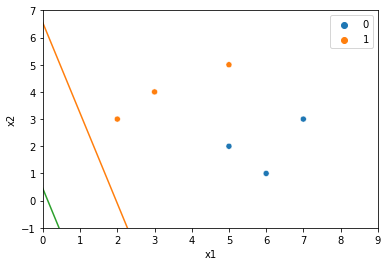

In [525]:
model=svc(input_dim=2)
model.plot_2D_svc(df[['x1','x2']],df.y)
print('margin : ',np.sqrt(model.params[0]**2+model.params[1]**2))

initial cost: 2.2773891111851756
initial margin: 3.518655527515115
final cost: 0.2015016351632249
final margin: 3.2620792759615433


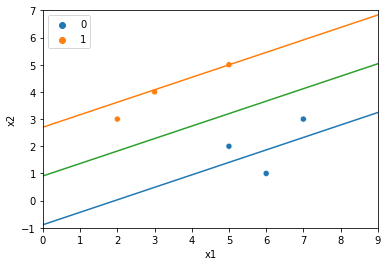

In [526]:
model.fit(df[['x1','x2']],df.y,alpha=0.05,n_epochs=1000,batch_size=6,optimizer_type='adam')
model.plot_2D_svc(df[['x1','x2']],df.y)

In [527]:
model.predict_distance(df[['x1','x2']])

array([ 0.65502059,  0.95670921,  1.00279977, -0.6690603 , -1.48194505,
       -0.62296974])

In [494]:
from sklearn.svm import LinearSVC
skmodel=LinearSVC(loss='hinge')
skmodel.fit(df[['x1','x2']],df.y)
skmodel.predict(df[['x1','x2']])

array([1, 1, 1, 0, 0, 0])

# Tests

In [306]:
if __name__ == "__main__":
    #test all the features of the handmade_nn class
    from unittest import TestCase

## compute_activation function tests

In [8]:
    #---------------------------------------------------------------------------
    ## tests for function compute_activation
    #---------------------------------------------------------------------------

    assert (compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                               'relu') ==\
            np.array([[0,0], [0, 1], [1, 3]]))\
            .all(), "uncorrect relu function behaviour"

    #---------------------------------------------------------------------------
    assert (compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                               'linear') ==\
            np.array([[-1,0], [0, 1], [1, 3]]))\
            .all(), "uncorrect linear function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                                        'sigmoid'), decimals= 8) ==\
            np.array([[0.26894142, 0.5       ],
                      [0.5       , 0.73105858],
                      [0.73105858, 0.95257413]]))\
            .all(), "uncorrect sigmoid function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                                        'tanh'), decimals= 8) ==\
            np.array([[-0.76159416,  0.        ],
                      [ 0.        ,  0.76159416],
                      [ 0.76159416,  0.99505475]]))\
            .all(), "uncorrect tanh function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                                        'softmax'), decimals= 8) ==\
            np.array([[0.09003057, 0.04201007],
                      [0.24472847, 0.1141952 ],
                      [0.66524096, 0.84379473]]))\
            .all(), "uncorrect softmax function behaviour"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_activation(0,'typo_error')
    assert 'Unknown activation type' in str(context.exception),\
        "no or wrong Exception raised when inputing an unknown activation_type\
         while calling compute_activation"

## compute_activation_derivative function tests

In [9]:
    #---------------------------------------------------------------------------
    ## tests for function compute_activation_derivative
    #---------------------------------------------------------------------------

    assert (compute_activation_derivative(np.array([[0,0], [0, 1], [1, 3]]),
                                          'relu') ==\
            np.array([[0,0], [0, 1], [1, 1]]))\
            .all(), "uncorrect relu function behaviour"

    #---------------------------------------------------------------------------
    assert (compute_activation_derivative(np.array([[-1,0], [0, 1], [1, 3]]),
                                          'linear') ==\
            np.array([[1,1], [1, 1], [1, 1]]))\
            .all(), "uncorrect linear function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation_derivative\
                     (np.array([[0.26894142, 0.5       ],
                                [0.5       , 0.73105858],
                                [0.73105858, 0.95257413]]),
                      'sigmoid'), decimals= 8) ==\
            np.array([[0.19661193, 0.25      ],
                      [0.25      , 0.19661193],
                      [0.19661193, 0.04517666]]))\
            .all(), "uncorrect sigmoid function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation_derivative\
                     (np.array([[-0.76159416,  0.        ],
                                [ 0.        ,  0.76159416],
                                [ 0.76159416,  0.99505475]]),
                                        'tanh'), decimals= 8) ==\
            np.array([[0.41997434, 1.        ],
                      [1.        , 0.41997434],
                      [0.41997434, 0.00986604]]))\
            .all(), "uncorrect tanh function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation_derivative\
                     (np.array([[0.09003057, 0.04201007],
                                [0.24472847, 0.1141952 ],
                                [0.66524096, 0.84379473]]),
                                        'softmax'), decimals= 8) ==\
            np.array([[0.08192507, 0.04024522],
                      [0.18483645, 0.10115466],
                      [0.22269543, 0.13180518]]))\
            .all(), "uncorrect softmax function behaviour"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_activation_derivative(0,'typo_error')
    assert 'Unknown activation type' in str(context.exception),\
        "no or wrong Exception raised when inputing an unknown activation_type\
         while calling compute_activation_derivative"

## predict method tests without hidden_layers

In [11]:
    #---------------------------------------------------------------------------
    ## tests for method predict - normal mode (without intermediate states) ####
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(5)# Empty neural network : just a pass-through for 5-values inputs

    assert my_nn.predict([2,3,2,3,4]).shape == (1,5),\
        "list not supported as an input for predict"
    #---------------------------------------------------------------------------

    assert my_nn.predict([[2,3,2,3,4],[-2,-1,1,3,4]]).shape == (2,5),\
        "list of list not supported as an input for predict"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        my_nn.predict(np.array([[[1,1],[1,2],[1,3],[1,4],[1,5]],
                                    [[2,1],[2,2],[2,3],[3,4],[3,5]]]))
    assert 'X vector dimension too high' in str(context.exception),\
        "no or wrong Exception raised when inputing a 3D-array in predict method"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        my_nn.predict(np.array([[1,1],[1,2],[1,3],[1,4],[1,5]]))
    assert 'Unconsistent number of features' in str(context.exception),\
        "no or wrong Exception raised when inputing a X\
         with unconsistant size vs. network input_dim in predict method"

    #---------------------------------------------------------------------------
    my_nn=handmade_nn(5)
    my_nn.add_dense_layer(10, 'linear')
    my_nn.weights[0] = np.vstack((np.identity(5),np.zeros((5,5))))
    assert my_nn.predict(np.array([-2,-1,2,3,4])).shape == (1,10),\
        "1-D array not supported as an input for predict method"

    #---------------------------------------------------------------------------
    my_nn=handmade_nn(5)
    my_nn.add_dense_layer(10, 'linear')
    my_nn.weights[0] = np.vstack((np.identity(5),np.zeros((5,5))))
    assert my_nn.predict(np.array([[-2,-1,2,3,4],
                                         [-12,-11,12,13,14]])).shape == (2,10),\
        "the shape of the prediction for a 2*5 X input\
         by a network having 10neurons on last layer should be 2*10"
    
    #--General-test-of-predict-method-with-all-activation-types-----------------
    my_nn=handmade_nn(5)

    my_nn.add_dense_layer(10, 'relu')
    my_nn.weights[-1] = np.concatenate([np.identity(5), np.zeros((5,5))], axis=0)
    my_nn.bias[-1] = np.array([0,0,0,0,1,1,1,0,0,0])

    my_nn.add_dense_layer(10, 'linear')
    my_nn.weights[-1] = np.flip(np.identity(10), 1)
    my_nn.bias[-1] = np.array([1,1,1,1,1,1,0,0,0,0])

    my_nn.add_dense_layer(10, 'tanh')
    my_nn.weights[-1] = np.identity(10)
    my_nn.bias[-1] = np.array([0,0,0,0,1,1,1,1,0,0])

    my_nn.add_dense_layer(10, 'softmax')
    my_nn.weights[-1] = np.flip(np.identity(10), 1)
    my_nn.bias[-1] = np.array([0,0,0,0,0,0,1,1,1,1])

    my_nn.add_dense_layer(1, 'sigmoid')
    my_nn.weights[-1] = np.expand_dims(np.arange(1,11,1), axis=0)
    my_nn.bias[-1] = np.array([0.5])


    assert np.round(my_nn.predict([-2,-1,2,3,4])[0,0], decimals=8) == 0.99939824,\
        "the general test of predict method on a network involving\
         all activation types and manually set bias and weights\
         did not return the correct value" 


## compute_metric function tests - normal mode

In [13]:
    #---------------------------------------------------------------------------
    ### tests for function compute_metric - normal mode (not derivative)########
    #---------------------------------------------------------------------------

    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric(np.array([[[1,1],[1,2]],
                                 [[2,1],[2,2]]]),
                       np.array([[1,2],
                                 [3,4]]),
                       'mse')
    assert 'y vector dimension too high' in str(context.exception),\
        "no or wrong Exception raised when inputing a 3D-array as y\
         in compute_metric function"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric(np.array([[1,2],
                                 [3,4]]),
                       np.array([[[1,1],[1,2]],
                                 [[2,1],[2,2]]]),
                       'mse')
    assert 'y_pred vector dimension too high' in str(context.exception),\
        "no or wrong Exception raised when inputing a 3D-array as y_pred\
         in compute_metric function"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric(np.array([[1,2,3],
                                 [4,5,6]]),
                       np.array([[1,2],
                                 [3,4]]),
                       'mse')
    assert 'unconsistent vectors dimensions' in str(context.exception),\
        "no or wrong Exception raised when inputing unconsistent\
         y vs y_pred vectors shapes in compute_metric function"

    #---------------------------------------------------------------------------
    assert compute_metric([1,0],[0.5,1],'mse') == 0.625,\
        "uncorrect mse metric behaviour"

    #---------------------------------------------------------------------------
    assert compute_metric([[1,0],[0,0]],[[0.5,1],[1,1]],'mse') == 0.8125,\
        "uncorrect mse metric behaviour for multi-features regressions\
         (2D y and y_pred vectors)"

    #---------------------------------------------------------------------------
    assert compute_metric([1,0],[0.5,1],'mae') == 0.75,\
        "uncorrect mae metric behaviour"

    #---------------------------------------------------------------------------
    assert np.round(compute_metric([[1,0,0],[0,1,0]],[[0.8,0.1,0.1],[0.2,0.6,0.2]],
                                   'categorical_crossentropy'),
                    decimals=8) == 0.36698459,\
        "uncorrect categorical_crossentropy metric behaviour"

    #---------------------------------------------------------------------------
    assert np.round(compute_metric([1,0],[0.9,0.1],'binary_crossentropy'),
                    decimals=8) == 0.10536052,\
        "uncorrect binary_crossentropy metric behaviour"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric([[1,0,1],[0,0,0]],
                       [[0.5,0.9,0.1],
                        [0.9,0.9,0.1]],
                       'binary_crossentropy')
    assert '1 max for binary_crossentropy' in str(context.exception),\
        "no or wrong Exception raised when inputing 2D y/y_pred vectors\
         with binary_crossentropy selected in compute_metric function"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric([0],[0],'typo_error')
    assert 'Unknown metric' in str(context.exception),\
        "no or wrong Exception raised when inputing\
         unknown metric in compute_metric function"

## compute_metric function tests - derivative mode

In [101]:
    #---------------------------------------------------------------------------
    ### tests for function compute_metric - derivative mode ####################
    #---------------------------------------------------------------------------

    assert len(compute_metric([1,0],[0.5,1],'mse', loss_derivative = True)\
               .shape) == 2,\
        "uncorrect output : compute_metric must return a 2D array in derivative mode"

    #---------------------------------------------------------------------------    
    assert (compute_metric([1,0],[0.5,1],'mse', loss_derivative = True)\
                == np.array([[-0.5],[1]])).all(),\
        "uncorrect mse metric behaviour in derivative mode"

    #---------------------------------------------------------------------------
    assert (compute_metric([[1,0],[0,0]],[[0.5,1],[1,1]],'mse',
                       loss_derivative = True)\
                == np.array([[-0.25, 0.5],[0.5, 0.5]])).all(),\
        "uncorrect mse metric behaviour for multi-features regressions\
         (2D y and y_pred vectors) in derivative mode"

    #---------------------------------------------------------------------------
    assert (compute_metric([1,0],[0.5,1],'mae', loss_derivative = True)\
                == np.array([[-0.5],[0.5]])).all(),\
        "uncorrect mae metric behaviour in derivative mode"

    #---------------------------------------------------------------------------
    assert (np.round(compute_metric([[1,0,0],[0,1,0]],[[0.8,0.1,0.1],[0.2,0.6,0.2]],
                                   'categorical_crossentropy',
                                   loss_derivative = True),
                    decimals=8) == np.array([[-0.625, -0.        , -0.],
                                             [-0.   , -0.83333333, -0.]])).all(),\
        "uncorrect categorical_crossentropy metric behaviour in derivative mode"

    #---------------------------------------------------------------------------
    assert (np.round(compute_metric([1,0],[0.9,0.1],
                                   'binary_crossentropy',
                                   loss_derivative = True),
                    decimals=8) == np.array([[-0.55555556],
                                             [ 0.55555556]])).all(),\
        "uncorrect binary_crossentropy metric behaviour in derivative mode"

## compute_backpropagation method tests

In [33]:
    #---------------------------------------------------------------------------
    ### tests for backpropagation method (computing the gradient) ##############
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(input_dim = 2)
    my_nn.add_dense_layer(2, 'linear', weights_initializer='ones')
    my_nn.add_dense_layer(1, 'linear', weights_initializer='ones')
    my_nn.set_loss('mse')
    
    outputs = my_nn.compute_backpropagation(np.array([[1,2],[2,3],[3,4]]), np.array([4,5,6]))
    n_outputs = len(np.array(outputs))
    output_type = type(outputs)
    assert output_type == tuple,\
        f"backpropagation method must return a tuple. type is {output_type}"
    
    #---------------------------------------------------------------------------
    assert n_outputs == 2,\
        f"backpropagation method must return 2 output. here returns {n_outputs}"
    
    gradient_weights, gradient_bias = outputs
    
    #---------------------------------------------------------------------------
    assert len(gradient_weights) == 2,\
        "using backpropagation: the list of weights has not correct length"
    
    #---------------------------------------------------------------------------
    assert len(gradient_bias) == 2,\
        "using backpropagation: the list of bias has not correct length"
    
    #---------------------------------------------------------------------------
    assert (gradient_weights[0] == np.array([[24., 34.],
                                             [24., 34.]])).all(),\
        "using backpropagation: uncorrect gradient with respect to weights"
    
    #---------------------------------------------------------------------------
    assert (gradient_bias[0] == np.array([10., 10.])).all(),\
        "using backpropagation: uncorrect gradient with respect to bias"

## fit method tests

In [9]:
    #---------------------------------------------------------------------------
    ### tests for fit method
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(input_dim = 2)
    my_nn.add_dense_layer(1, 'linear',)
    X= np.ones((10_000, 2))
    y= np.zeros((10_000,1))
    my_nn.fit(X,y, loss='mse',optimizer_type='sgd', batch_size=7, n_epochs=2)
    
    assert my_nn.score(X,y,'mse') < 0.5,\
        "fit method has not converged with build-in sgd optimizer on a trivial regression"

initial loss: 17.675491017786463
final loss: 7.099748146989106e-30


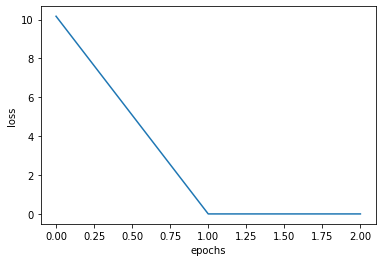

In [38]:
my_nn.plot_loss_history()

## optimizers tests

In [12]:
    #---------------------------------------------------------------------------
    ### tests for optimizers
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(input_dim = 2)
    my_nn.add_dense_layer(1, 'linear',)
    X= np.ones((10_000, 2))
    y= np.zeros((10_000,1))
    my_nn.fit(X,y, loss='mse',optimizer_type='adam', batch_size=7, n_epochs=2)
    
    assert my_nn.score(X,y,'mse') < 0.5,\
        "not converged with adam optimizer on a trivial regression"
    
    my_nn.loss_history

initial loss: 1.235009060819703
final loss: 9.321500930834222e-30


[1.235009060819703, 7.841921513571235e-10, 9.321500930834222e-30]

# Trash section : small tests, to be deleted

In [227]:
df=pd.DataFrame({'x1':[2,3,5,5,6,7],'x2':[3,4,5,2,1,3],'y':[1,1,1,0,0,0]})
df

,x1,x2,y
0,2,3,1
1,3,4,1
2,5,5,1
3,5,2,0
4,6,1,0
5,7,3,0


In [210]:
aa=2/3
bb=-1
cc=0.5

compute_line_points(aa,bb,cc)

([82.97450021717695, -83.4360386787154],
 [55.81633347811797, -55.12402578581027])

[(-1.0, 7.0)]

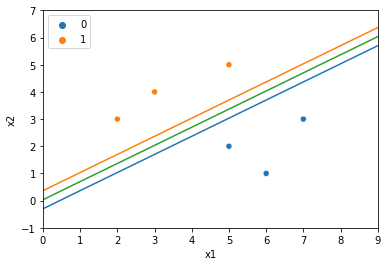

In [232]:
xx=df[['x1','x2']]
yy=df['y']
ww=[-2,3]
bb=-0.1
xline, yline = compute_line_points(ww[0],ww[1],bb)
xlineup, ylineup = compute_line_points(ww[0],ww[1],bb-1)
xlinedown, ylinedown = compute_line_points(ww[0],ww[1],bb+1)

g=sns.scatterplot(data=df,x='x1',y='x2',hue='y')
sns.lineplot(x=xlinedown, y=ylinedown)
sns.lineplot(x=xlineup, y=ylineup)
sns.lineplot(x=xline, y=yline)
g.set(xlim=(df.x1.min()-2,df.x1.max()+2))
g.set(ylim=(df.x2.min()-2,df.x2.max()+2))

In [218]:
np.array(yy)

array([ 1,  1,  1, -1, -1, -1])

In [219]:
np.dot(np.array(xx),[1,2])*np.array(yy)

array([  8,  11,  15,  -9,  -8, -13])

In [220]:
ww

[-2, 3]

In [221]:
(np.dot(np.array(xx),np.array(ww))-bb)*np.array(yy)

array([5.1, 6.1, 5.1, 3.9, 8.9, 4.9])

In [222]:
np.maximum(0,(1-(np.dot(np.array(xx),np.array(ww))-bb)*np.array(yy)))

array([0., 0., 0., 0., 0., 0.])

In [228]:
compute_softmargin_hinge(xx,yy,np.array(list(ww)+[bb]),0.01)

x (6, 2)
y (6,)
w (2,)
b -0.1


(0.13, array([0., 0., 0., 0., 0., 0.]))

In [241]:
compute_softmargin_hinge_derivative(xx,yy,np.array(list(ww)+[bb]),0.01)

y :  (6,)
dw2_dparams :  [-0.04  0.06  0.  ]
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]]


ValueError: operands could not be broadcast together with shapes (2,) (3,) 

In [121]:
apres_abattement = 0.66*apres_cotiz

In [122]:
chomage=2000
chomage_reduit=chomage-0.7*apres_abattement

In [123]:
total=chomage_reduit+apres_cotiz

In [124]:
gain = (total-chomage)/recu_wagon
gain

0.4788200000000002

In [133]:
(np.array([-1,2,1])>0)*[1,2,3]

array([0, 2, 3])

In [138]:
tab=np.array([[1,2],[3,4],[5,6],[7,8],[9,10]])*np.array([[1],[2],[3],[4],[5]])

In [145]:
(tab*(np.expand_dims(np.array([1,2,3,2,3])>2,axis=1))).mean(axis=0)

array([12. , 13.6])

In [229]:
from sklearn.svm import LinearSVC

In [465]:
w=np.array([-1,2,3])
np.divide(w, np.absolute(w))

array([-1.,  1.,  1.])